### Libraries

In [1]:
import numpy as np
import random
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from sklearn import preprocessing
import pylab as plt
%matplotlib inline

Using TensorFlow backend.
/home/patrik/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Config

In [2]:
# Network
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.001)

# Samples
nb_samples = 5000 # generated samples number
test_split = 0.25 # train and test samples split

# Genetic algorithm
n_creatures = 10
n_generation = 10
max_layer_num = 5
max_neuron_num = 100
mutation_rate = 0.05

### Generate samples

In [3]:
# Generate samples
samples = np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0, nb_samples, 4):
    noise = np.random.normal(0, 1, 8)
    samples[i] = (-2 + noise[0], -2 + noise[1]), 0
    samples[i+1] = (2 + noise[2], -2 + noise[3]), 1
    samples[i+2] = (-2 + noise[4], 2 + noise[5]), 1
    samples[i+3] = (2 + noise[6], 2 + noise[7]), 0

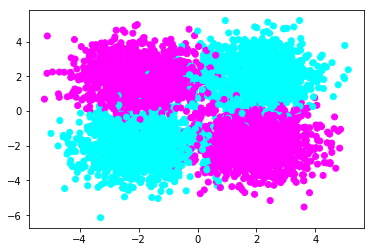

In [4]:
# Show samples
fig1 = plt.figure()
plt.scatter(samples['input'][:, 0], samples['input'][:, 1], c=samples['output'][:], cmap=plt.cm.cool)

In [5]:
# Split train and test samples
split_limit = int( nb_samples * (1 - test_split) )
samples_train = samples[:split_limit]
samples_test  = samples[split_limit:]

print('Train samples number: %d' % len(samples_train))
print('Test samples number: %d' % len(samples_test))

Train samples number: 3750
Test samples number: 1250


In [6]:
# Standardization
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_test['input'] = scaler.transform(samples_test['input'])    

In [7]:
# Make parameters
train_params = (samples_train['input'], samples_train['output'], samples_test['input'], samples_test['output'])
test_params = (samples_test['input'], samples_test['output'])

### Neural Network

In [8]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.build_model()
        self.model.compile(loss='mse', optimizer=optimizer)
        
    def build_model(self):
        x = h = Input(shape=(2,))
        for layer in self.layers:
            if layer > 0:
                h = Dense(layer, activation='sigmoid')(h)
        h = Dense(1, activation='sigmoid')(h)
        self.model = Model(x, h)
        
    def summary(self):
        self.model.summary()
        
    def train(self, x_train, y_train, x_test, y_test, n_epoch=None):
        self.model.fit(
            x=x_train, y=y_train,
            batch_size=batch_size,
            epochs=epochs if n_epoch == None else n_epoch,
            validation_data=(x_test, y_test),
            shuffle=True, verbose=0
        )
        
    def test(self, x_test, y_test):
        loss = self.model.evaluate(x=x_test, y=y_test, verbose=0)
        return loss
    
    def predict(self, x):
        preds = self.model.predict(x)
        return preds

### Genetic algorithm

In [9]:
# Create first population
population = []
for _ in range(n_creatures):
    layers_num = random.randint(0, max_layer_num)
    layers = [0] * max_layer_num
    for i in range(layers_num):
        layers[i] = random.randint(1, max_neuron_num)
    creature = {'layers': layers, 'fitness': None}
    population.append(creature)

In [10]:
# Show first population
for i, creature in enumerate(population):
    print('%d. Creature: %s' % (i+1, ' '.join(str(layer) for layer in creature['layers'] if layer > 0)))

1. Creature: 18 78
2. Creature: 74 61 9
3. Creature: 37
4. Creature: 5
5. Creature: 20 68 28
6. Creature: 90 17 52
7. Creature: 29 63 91
8. Creature: 
9. Creature: 31
10. Creature: 


In [11]:
# Define cross_creatures function
def cross_creatures(creature_a, creature_b):
    layers_a = creature_a['layers'][:]
    layers_b = creature_b['layers'][:]
    for i in range(max_layer_num):
        if random.random() <= mutation_rate:
            layers_a[i] = random.randint(1, max_neuron_num)
        elif random.random() > 0.5:
            layers_a[i] = layers_b[i]
    layers = [layer for layer in layers_a if layer > 0]
    for _ in range(max_layer_num - len(layers)):
        layers.append(0)
    return {'layers': layers, 'fitness': None}

In [12]:
# Create a new generation from the old
# The old_population parameter should be sorted
def new_generation(old_population):
    new_population =  []
    for i, creature in enumerate(old_population):
        chance = (n_creatures - i) / n_creatures
        if random.random() < chance:
            new_population.append(creature)
    for i in range(n_creatures - len(new_population)):
        creature = cross_creatures(old_population[i], old_population[i+1])
        new_population.append(creature)
    for creature in new_population:
        creature['fitness'] = None
    return new_population

In [13]:
# Calculate fitnesses
def test_creatures(creatures):
    for creature in creatures:
        NN = NeuralNetwork(creature['layers'])
        NN.train(*train_params)
        creature['fitness'] = NN.test(*test_params)

In [14]:
best_creature = population[0]

for generation in range(1, n_generation+1):
    print('Generation: %d' % generation)
    test_creatures(population)
    
    population = sorted(population, key=lambda creature: creature['fitness'], reverse=False)
    if population[0]['fitness'] < best_creature['fitness']:
        best_creature = population[0]
        
    fitnesses = [creature['fitness'] for creature in population]
    print('Best fitness: %f' % min(fitnesses))
    print('Average fitness: %f' % np.mean(fitnesses))
    if generation < n_generation:
        population = new_generation(population)
        print()

Generation: 1
Best fitness: 0.037206
Average fitness: 0.164890

Generation: 2
Best fitness: 0.033188
Average fitness: 0.096222

Generation: 3
Best fitness: 0.031840
Average fitness: 0.059919

Generation: 4
Best fitness: 0.033380
Average fitness: 0.055344

Generation: 5
Best fitness: 0.029949
Average fitness: 0.046765

Generation: 6
Best fitness: 0.035179
Average fitness: 0.057489

Generation: 7
Best fitness: 0.031773
Average fitness: 0.048149

Generation: 8
Best fitness: 0.029669
Average fitness: 0.047654

Generation: 9
Best fitness: 0.028566
Average fitness: 0.047050

Generation: 10
Best fitness: 0.026506
Average fitness: 0.046475


### Result

In [15]:
print('Layers: %s' % ' '.join(str(layer) for layer in best_creature['layers'] if layer > 0))

Layers: 20 63 28 92


In [16]:
# Train the best
NN = NeuralNetwork(best_creature['layers'])
NN.train(*train_params, 100)

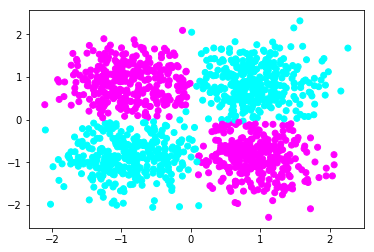

In [17]:
# Show the result
preds = NN.predict(samples_test['input'])
fig1 = plt.figure()
plt.scatter(samples_test['input'][:,0], samples_test['input'][:,1], c=np.round(preds[:]), cmap=plt.cm.cool)